In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'Volatility': "{:.2%}",'Active Risk': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles))
    
    return corr

## Momentum Backtest

To do
- add volatility
- add fundamental data
- try different things
    - Acceleration
- Use daily data 
- Add rebalancing options, daily, monthly...

In [4]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]

In [5]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

### SETTINGS FOR BACKTEST

In [292]:

FREQ = 'Monthly'
top_n = 10
rebal_period = 1
min_MCAP = 500000000
not_secors = ['finance_RE'] #'finance_RE'
not_markets = []

close_df=close_df[ ~close_df['sector'].isin(not_secors)]
close_df=close_df[ ~close_df['market'].isin(not_markets)]
close_df = close_df[close_df['MCAP']<min_MCAP]

In [293]:
## Resample to monthly
if FREQ == 'Monthly':
    data_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
elif FREQ == 'Daily':
    data_df = close_df.copy()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std = x.EA_ret/x.volatility_60day))

#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)
data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)
data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)




### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True



data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [294]:
### FUNDAMENTAL RANKS

##VALUATION MEASURES
data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df[data_df['PE']< 0]['PE'] = data_df['PE'].max()
data_df[data_df['PB']< 0]['PB'] = data_df['PB'].max()

data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good

data_df[data_df['EVEBIT']< 0]['EVEBIT'] = data_df['EVEBIT'].max()
data_df[data_df['EVFCF']< 0]['EVFCF'] = data_df['EVFCF'].max()


data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good


### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [295]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.PE_rank + x.GPA_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_mom_rank ))#VQ



data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(value_composite = x.PE_rank + x.ag_rank ))#VQ
data_df['VC_rank'] = data_df['value_composite'].groupby(level='d').rank(ascending=True)  #should be True

### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.PE_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC_rank + x.GPA_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [296]:
### ANTI STRATEGIES
data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True

### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [297]:
strat_df = pd.DataFrame()
strats_test = ['comb_mom_rank', 'ear_std_mom_rank', 'focus_mom_rank', 'mom_vol_rank', 'VQ_rank', 'VMQ_rank']


for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [298]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [299]:
#result['SISU'] = 0.7*result['VMQ_rank'] + 0.3*result['focus_mom_rank']


In [300]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

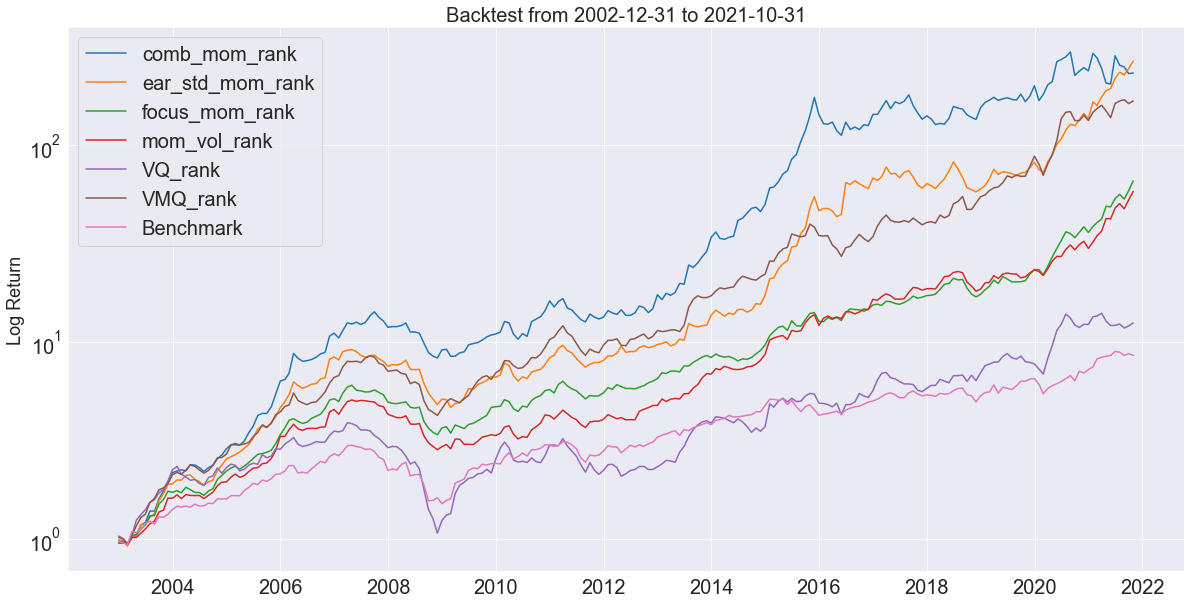

In [301]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [302]:
data_names = result.columns
strategy_evaluation(result_cum,data_names,freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,Active Risk,IR
comb_mom_rank,33.67%,28.40%,1.19,1.98,-42.00%,0.8,27.30%,0.67
ear_std_mom_rank,34.49%,24.30%,1.42,2.87,-49.00%,0.7,23.20%,0.81
focus_mom_rank,24.97%,17.10%,1.46,2.5,-44.00%,0.57,14.70%,0.71
mom_vol_rank,24.32%,17.70%,1.37,2.21,-44.00%,0.55,15.10%,0.66
VQ_rank,14.09%,24.40%,0.58,0.94,-73.00%,0.19,20.50%,0.06
VMQ_rank,31.02%,22.30%,1.39,2.39,-50.00%,0.62,20.60%,0.77
Benchmark,12.20%,16.20%,0.75,0.94,-50.00%,0.24,0.00%,0


In [291]:
correlation_map(result_cum)

,comb_mom_rank,ear_std_mom_rank,focus_mom_rank,mom_vol_rank,VQ_rank,VMQ_rank,Benchmark
comb_mom_rank,1.00,0.90,0.72,0.71,0.64,0.70,0.50
ear_std_mom_rank,0.90,1.00,0.85,0.83,0.70,0.76,0.60
focus_mom_rank,0.72,0.85,1.00,0.94,0.70,0.77,0.69
mom_vol_rank,0.71,0.83,0.94,1.00,0.69,0.75,0.68
VQ_rank,0.64,0.70,0.70,0.69,1.00,0.83,0.59
VMQ_rank,0.70,0.76,0.77,0.75,0.83,1.00,0.59
Benchmark,0.50,0.60,0.69,0.68,0.59,0.59,1.00


In [212]:
rel_result = result.subtract((pd.Series(result['Benchmark'])), axis = 0)
rel_result = rel_result.drop(['Benchmark'], axis= 1)

In [213]:
Roll_Max = (rel_result+1).cumprod().cummax()
Daily_Drawdown = (rel_result+1).cumprod()/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)

rel_perf_df = pd.DataFrame( columns = Max_Daily_Drawdown.columns, index=['Max rel. DD','Longest rel. DD'])
rel_perf_df.loc['Max rel. DD',:] = Max_Daily_Drawdown.values


In [215]:
rel_perf_df

,comb_mom_rank,ear_std_mom_rank,focus_mom_rank,mom_vol_rank
Max rel. DD,-0.47,-0.35,-0.33,-0.42
Longest rel. DD,NaN,NaN,NaN,NaN


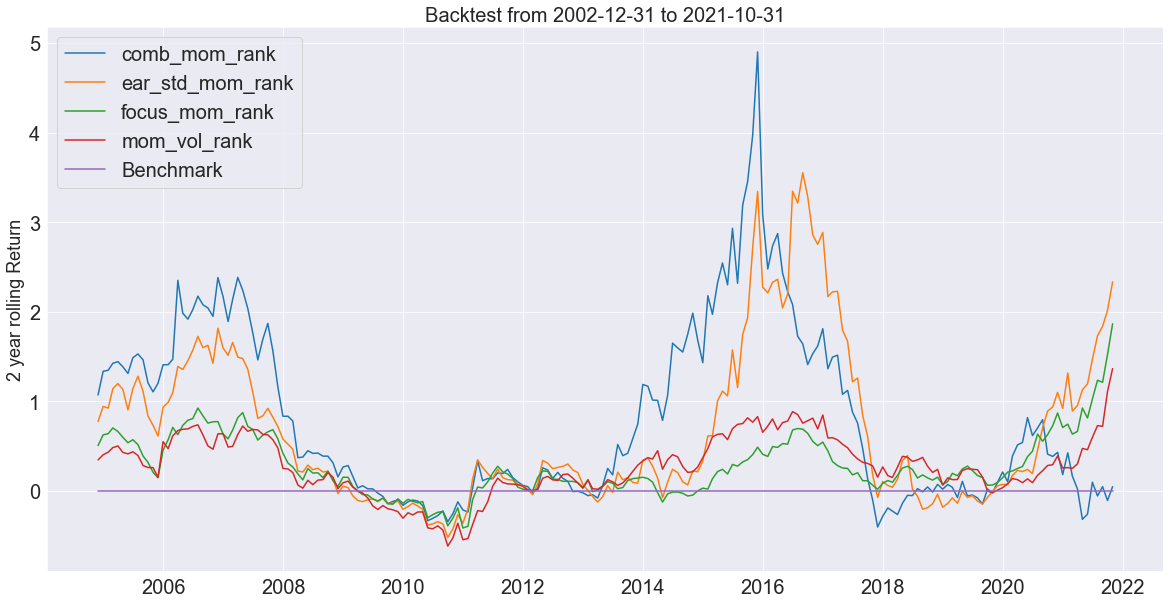

In [216]:
rolling_performance = (1.+result).rolling(window=2*12).agg(lambda x : x.prod()).dropna()
rolling_performance = rolling_performance.subtract(pd.Series(rolling_performance['Benchmark']), axis = 0)



sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in rolling_performance.columns:
    plt.plot(rolling_performance[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.ylabel('2 year rolling Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [217]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1

## Performance by rebalancing date

- measure by sharpe ratio

In [218]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [219]:
rebal_diff_df

,1,2,3,4,5,6,7,8,9,10,11,12
comb_mom_rank,1.10536,1.18383,1.04027,1.01754,0.909353,1.02376,0.935254,0.93702,0.793481,0.816803,0.862014,1.02645
ear_std_mom_rank,1.28695,1.23206,1.00728,1.12966,0.91599,0.953387,1.12274,0.980314,0.83295,0.802318,0.892787,1.12116
focus_mom_rank,1.36281,1.40817,1.27416,1.23358,1.26248,1.31433,1.20152,1.04291,1.04586,1.03246,1.08207,1.3624
mom_vol_rank,1.26167,1.39035,1.21584,1.19557,1.29607,1.34832,1.22334,1.11073,0.982395,1.09221,1.00541,1.22967


In [220]:
turnover_df

,1,2,3,4,5,6,7,8,9,10,11,12
comb_mom_rank,5.27162,3.57904,2.9345,2.35808,1.93886,1.67162,1.46201,1.26812,1.18952,1.02183,0.953712,0.90131
ear_std_mom_rank,5.03843,3.43493,2.88472,2.25066,1.89432,1.669,1.43319,1.2655,1.17118,1.02445,0.940611,0.89345
focus_mom_rank,5.11441,3.46376,2.78253,2.18515,1.82358,1.58253,1.39389,1.25764,1.1476,1.04803,0.932751,0.854148
mom_vol_rank,5.58079,3.74148,2.91354,2.2952,1.84978,1.6821,1.45153,1.28908,1.16856,1.04279,0.974672,0.89607


##  Save returns as pandas dataframe

In [26]:
result.to_csv("data/strategy_returns.csv")